# Import Needed Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss,recall_score,precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , label_binarize
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Load Data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_data = datasets.STL10(root='./data', split='test', download=True, transform=transform)


100%|██████████| 2640397119/2640397119 [02:09<00:00, 20415920.27it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


# Processes On Data

In [3]:
def data_to_numpy(dataset):
    data = []
    labels = []
    for img, label in dataset:
        data.append(img.flatten())  
        labels.append(label)
    return np.array(data), np.array(labels)

X_train, y_train = data_to_numpy(train_data)
X_test, y_test = data_to_numpy(test_data)

In [4]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Evaluate Model

In [6]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)



KNeighborsClassifier()

In [7]:
y_pred_knn = knn.predict(X_test_scaled)

# Visualization

# Accuracy 

KNN Accuracy: 30.68%


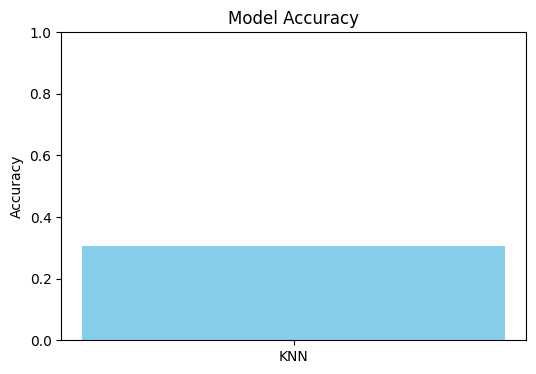

In [8]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")

# Visualize the accuracy
plt.figure(figsize=(6, 4))
plt.bar(['KNN'], [accuracy], color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.show()

# Loss Curve

KNN Best Loss (Simulated): 0.00


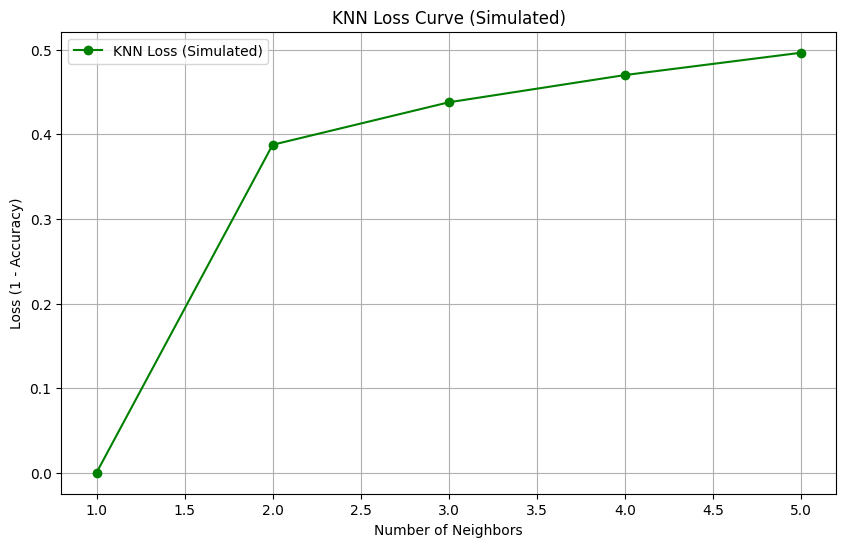

In [9]:
knn_losses = []
for k in range(1, 6):
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, knn_temp.predict(X_train_scaled))
    knn_losses.append(1 - train_acc)
 
knn_loss_val = min(knn_losses)  

print(f"KNN Best Loss (Simulated): {knn_loss_val:.2f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), knn_losses, label="KNN Loss (Simulated)", color="green", marker="o")
plt.xlabel("Number of Neighbors")
plt.ylabel("Loss (1 - Accuracy)")
plt.title("KNN Loss Curve (Simulated)")
plt.legend()
plt.grid()
plt.show()


# Confusion Matrix

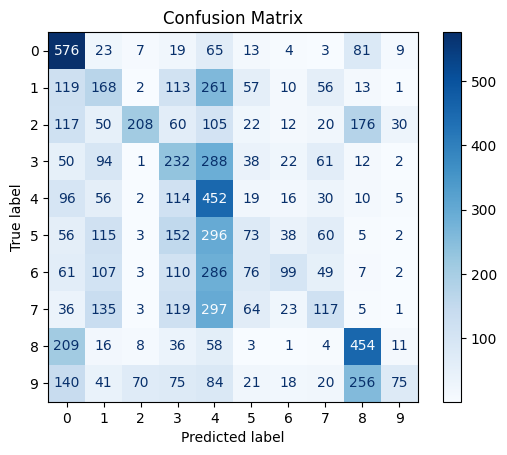

In [10]:
# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Precision

KNN Precision: 35.76%


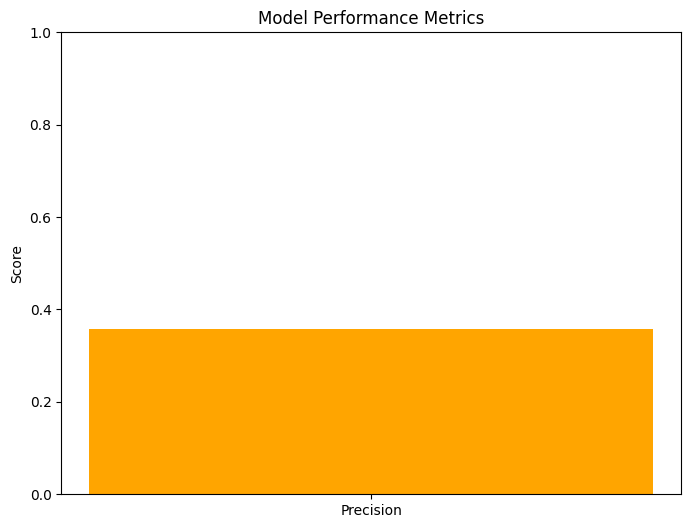

In [11]:
# Calculate the precision
precision = precision_score(y_test, y_pred_knn, average='weighted')
print(f"KNN Precision: {precision * 100:.2f}%")

# Visualize the accuracy and precision
plt.figure(figsize=(8, 6))
plt.bar([ 'Precision'], [ precision], color=[ 'orange'])
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()

# Recall

Logistic Regression Recall: 30.68%


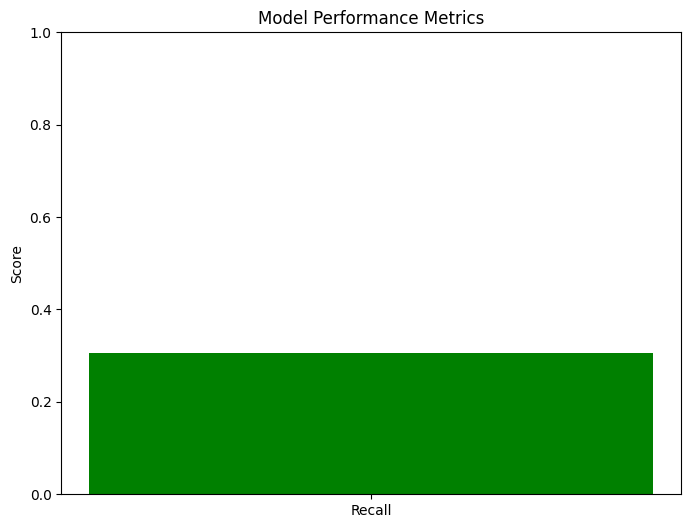

In [12]:
# Calculate the recall score
recall = recall_score(y_test, y_pred_knn, average='weighted')
print(f"Logistic Regression Recall: {recall * 100:.2f}%")

# Visualize the recall
plt.figure(figsize=(8, 6))
plt.bar(['Recall'], [recall], color=['green'])
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()


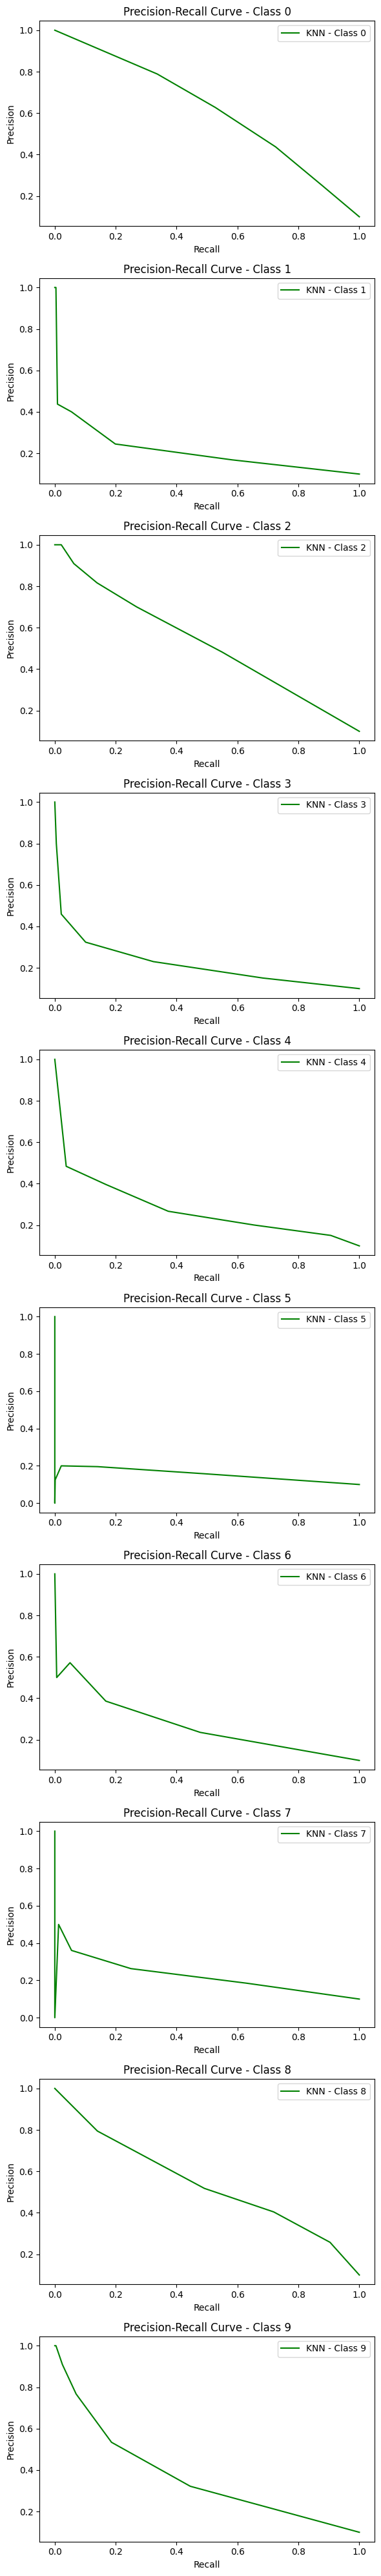

In [13]:
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))


y_proba_knn = knn.predict_proba(X_test_scaled)

precision_knn, recall_knn = {}, {}
fpr_knn, tpr_knn = {}, {}

# Compute Precision-Recall Curve and ROC Curve for each class
for i in range(y_train_bin.shape[1]):
    precision_knn[i], recall_knn[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba_knn[:, i])

    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])

# Plot Precision-Recall Curves for each class
num_classes = y_train_bin.shape[1]
fig, axes = plt.subplots(num_classes, 1, figsize=(6, 4 * num_classes))

for i in range(num_classes):
    axes[i].plot(recall_knn[i], precision_knn[i], color='green', label=f'KNN - Class {i}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Precision-Recall Curve - Class {i}')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [15]:
# Initialize dictionaries to store average precision and recall for each class
avg_precision_knn = {}
avg_recall_knn = {}

# Calculate average precision and recall for each class
for i in range(y_train_bin.shape[1]):
    avg_precision_knn[i] = average_precision_score(y_test_bin[:, i], y_proba_knn[:, i])
    avg_recall_knn[i] = recall_score(y_test_bin[:, i], y_proba_knn[:, i].round())  # rounding predicted probabilities to labels

# Calculate the mean of average precision and recall across all classes
mean_avg_precision_knn = np.mean(list(avg_precision_knn.values()))
mean_avg_recall_knn = np.mean(list(avg_recall_knn.values()))

# Print the results
print(f"Average Precision for KNN: {mean_avg_precision_knn:.2f}")
print(f"Average Recall for KNN: {mean_avg_recall_knn:.2f}")


Average Precision for KNN: 0.27
Average Recall for KNN: 0.19


# ROC & AUC

/tmp/ipykernel_24/1869637431.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', y_train_bin.shape[1])


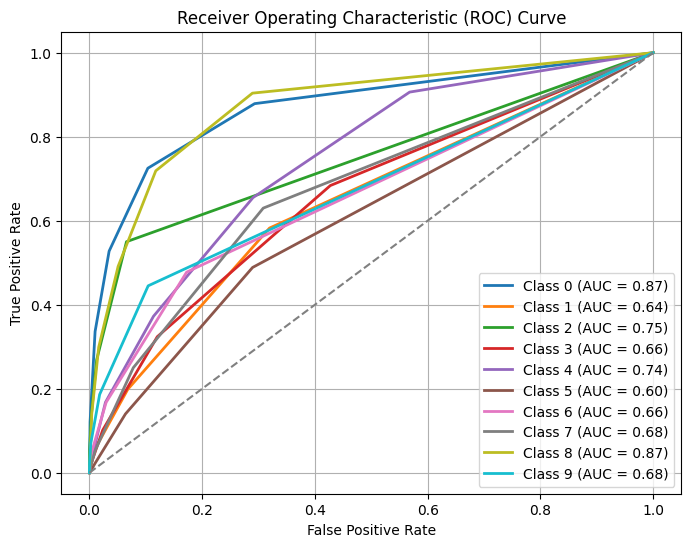

Class 0 - AUC: 0.87
Class 1 - AUC: 0.64
Class 2 - AUC: 0.75
Class 3 - AUC: 0.66
Class 4 - AUC: 0.74
Class 5 - AUC: 0.60
Class 6 - AUC: 0.66
Class 7 - AUC: 0.68
Class 8 - AUC: 0.87
Class 9 - AUC: 0.68


In [16]:
# Binarize the true labels for multiclass classification
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Dictionaries to store FPR, TPR, and AUC for each class
fpr_knn, tpr_knn, roc_auc_knn = {}, {}, {}

# Compute ROC curve and AUC for each class
for i in range(y_train_bin.shape[1]):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))

# Dynamically generate colors based on the number of classes
colors = plt.cm.get_cmap('tab10', y_train_bin.shape[1])

for i in range(y_train_bin.shape[1]):
    plt.plot(fpr_knn[i], tpr_knn[i], color=colors(i), lw=2, label=f'Class {i} (AUC = {roc_auc_knn[i]:.2f})')

# Plot the diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Optionally, print AUC for each class
for i in range(y_train_bin.shape[1]):
    print(f"Class {i} - AUC: {roc_auc_knn[i]:.2f}")


In [17]:
auc_knn = {}

for i in range(y_train_bin.shape[1]):
    auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])  # AUC for KNN

avg_auc_knn = np.mean(list(auc_knn.values()))

print(f"Average AUC for KNN: {avg_auc_knn:.2f}")


Average AUC for KNN: 0.72
